## UNGA Resolutions: Search & Summarize
**Ashley Ferreira**

**January 15-17, 2023 @WesternU**

A notebook exploring the use of embeddings to perform semantic search and summarization on United Nations General Assembly Resolutions. Think of it very much as a rough "proof of concept", it for sure doesn't work perfectly. This can easily be extended to other UN documents though, I just found a good UNGA dataset :)

### Setup Software

In [1]:
import json
import cohere
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [2]:
# my API key has been redacted here
api_key = ''
co = cohere.Client(api_key)

### Prepare Data

In [3]:
# opening JSON file with UNGA resolution data
f = open('docs.json', 'r', encoding='utf-8')
   
# create dictionary from JSON object
data = json.load(f)

# close file
f.close()

From the Cohere API documentation: "An array of strings for the model to embed. Maximum number of texts per call is 96. We recommend reducing the length of each text to be under 512 tokens for optimal quality - texts longer than 512 tokens will be spliced and the resulting embeddings of each component are then averaged and returned. The token limit per text is 4096, and the minimum is 1 token."


Given this, I tried to keep my resolutions on the shorter size and only use 96 resolutions for now.

In [4]:
n = 1  
max_texts = 96 + 17 # 17 get dropped due to being duplicates
max_tokens = 1024 # 512 throws error for most reports being too long

# initialize blank lists to populate
title_lst = []
id_lst = []
date_lst = []
body_lst = []

# iterating through the json
for i in data:
    if n > max_texts:
        break
    response = i['response']

    if response['numFound'] > 0:
        docs = response['docs'][0]
    
        title = docs['title_en']
        print(title)
        id = docs['id']
        #print(id)
        date = docs['publicationDate']
        #print(date)
        body = docs['body_en']
        #print(body)

    # check body is not too long
    if len(body)//4 > max_tokens:
        print('too long')
        
    else:
        # append all needed data to lists
        n += 1
        title_lst.append(title)
        id_lst.append(id)
        date_lst.append(date)
        body_lst.append(body)

ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOODING EXPERIENCED IN RECENT MONTHS : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
THE DESTRUCTION OF RELICS AND MONUMENTS IN AFGHANISTAN : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
SECURITY COUNCIL RESOLUTION 1346 (2001) [ON EXTENSION OF THE MANDATE OF THE UN MISSION IN SIERRA LEONE (UNAMSIL)]
too long
SECURITY COUNCIL RESOLUTION 1340 (2001) [ON THE NOMINATIONS FOR PERMANENT JUDGES OF THE INTERNATIONAL TRIBUNAL FOR THE FORMER YUGOSLAVIA]
SECURITY COUNCIL RESOLUTION 1347 (2001) [ON ESTABLISHMENT OF THE LIST OF CANDIDATES NOMINATED FOR JUDGES OF THE INTERNATIONAL TRIBUNAL FOR RWANDA]
ORGANIZATIONAL ARRANGEMENTS FOR THE SPECIAL SESSION OF THE GENERAL ASSEMBLY ON HIV/AIDS AND ITS PREPARATORY PROCESS : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
too long
SECURITY COUNCIL RESOLUTION 1343 (2001) [ON THE SITUATION IN LIBERIA]
too long
CONDITIONS OF SERVICE AND COMPENSATION FOR THE AD LITEM JUDGES OF THE INTERNATIONAL TRIBUNAL FOR THE PROSECUTION 

In [5]:
# check total number of resolutions so far
print(len(body_lst))

113


### Embed Text & Perform PCA 

In [6]:
response = co.embed(body_lst)
X = response.embeddings
X = np.array(X)

In [7]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)

In [8]:
print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (113, 4096)
Shape after PCA:  (113, 2)


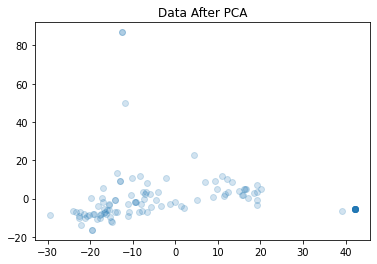

In [9]:
# plot 2 dimentions after PCA
x = []
y = []
for e in pca_features:
    x.append(round(e[0],4))
    y.append(round(e[1],4))
  
plt.title('Data After PCA')
plt.plot(x,y,'o',alpha=0.2)
plt.show()

In [57]:
# create data frame with data of interest
df = pd.DataFrame(list(zip(id_lst, date_lst, title_lst, x, y, body_lst)),
               columns =['id', 'date', 'title', 'x', 'y', 'body'])

In [58]:
# an example of the most inefficient way to do something
em_lst = []
for X_i in X:
    em_lst.append({'arr':X_i})

df['embeddings'] = em_lst

In [59]:
# remove duplicates
print('dataframe length with duplicate rows:', len(df))
df.drop_duplicates(subset=['id','title'], keep="first", inplace=True)
print('dataframe length without duplicate rows:', len(df))
df.head(5)

dataframe length with duplicate rows: 113
dataframe length without duplicate rows: 96


,id,date,title,x,y,body,embeddings
0,A/RES/55/241_en,2001-02-14T00:00:00Z,ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOOD...,-12.8779,9.1493,\nUnited Nations A/RES/55/241\n\nGeneral Assem...,"{'arr': [-0.5545409, -1.8062013, 0.5631694, 1...."
2,A/RES/55/243_en,2001-05-01T00:00:00Z,THE DESTRUCTION OF RELICS AND MONUMENTS IN AFG...,-2.2873,10.7551,\nUnited Nations A/RES/55/243\n\nGeneral Assem...,"{'arr': [1.0356977, -1.3506703, -1.8744687, 0...."
3,S/RES/1340(2001)_en,2001-02-08T00:00:00Z,SECURITY COUNCIL RESOLUTION 1340 (2001) [ON TH...,11.0662,11.8731,\nUnited Nations S/RES/1340 (2001)\n\n \n\nSec...,"{'arr': [-1.2039756, 0.026266381, 0.5417079, 0..."
4,S/RES/1347(2001)_en,2001-03-30T00:00:00Z,SECURITY COUNCIL RESOLUTION 1347 (2001) [ON ES...,12.1758,10.2691,\nUnited Nations S/RES/1347 (2001)\n\n \n\nSec...,"{'arr': [-0.9711914, 0.2919922, 0.71484375, 0...."
5,A/RES/55/249_en,2001-05-01T00:00:00Z,CONDITIONS OF SERVICE AND COMPENSATION FOR THE...,-10.1643,10.5838,\nUnited Nations A/RES/55/249\n\nGeneral Assem...,"{'arr': [-1.0319904, 0.5230692, -0.91887087, 1..."


### Summarize
Cut off response at \n\n (or first weird character like '=') since we only want one paragraph and it often starts to ramble with weird things...

In [60]:
summary_lst = []
summary_prompt = '\n\nTeacher Question: Provide a 1 paragraph summary of the text above.\n\nSecond Grade Student Answer:'# This UNGA resolution'

for body, title in zip(df['body'], df['title']): 
    response = co.generate( 
    model='xlarge', 
    prompt= body + summary_prompt,
    max_tokens=128, 
    temperature=0.8, 
    frequency_penalty=0.9, 
    presence_penalty=0.5,
    end_sequences=['\n\n','--','=','__'])

    summary = response.generations[0].text
    summary_lst.append(summary)
    print('###################')
    print(title)
    print(summary)

###################
ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOODING EXPERIENCED IN RECENT MONTHS : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
 The General Assembly adopted resolution 55/241. This was about help to flood victims in Bolivia. It expressed sorrow for the hard times experienced due to flooding, and commended Bolivia's people and government on helping flood victims get out of danger. The assembly requested member states, NGOs, UN specialized agencies and others provide assistance to Bolivia.
###################
THE DESTRUCTION OF RELICS AND MONUMENTS IN AFGHANISTAN : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
 This is about how the Taliban destroyed many things that belonged to other people's religions. Then, other countries tried to stop them and some countries did not like what they were doing. They thought this was very bad because the statues were important symbols for many different people. They are trying to keep it from happening again so we don't lose any more 

In [62]:
# add summaries to data frame and save as .csv
df['summary'] = summary_lst
df.to_csv('unga_embeddings_pca.csv', index=False)

### Search
Reference [documentation](https://docs.cohere.ai/docs/semantic-search) for great information on this

In [63]:
# semantic search on this question
query = "What is the UN doing on Terrorism and Nuclear Weapons?"

# get the query's embedding
query_embed = co.embed(texts=[query]).embeddings
query_embed = np.array(query_embed)


# get most similar embeddings from resolutions
similarity_lst = []
embeddings = df['embeddings']
for e in embeddings:
    X_new = np.array(e['arr']) 
    # x is (4096,) but want (1, 4096)
    X_new = np.array(X_new)
    X_new = X_new.reshape((1, 4096))
    
    # calculate cosine similarity
    similarity = cosine_similarity(X_new, query_embed)
    similarity_lst.append(similarity[0][0]) 

# sort by highest similarity
df['similarity'] = similarity_lst
df_sorted = df.sort_values(by=['similarity'], ascending=False) 

# save and display data frame
df_sorted.to_csv('unga_embeddings_all_sorted.csv', index=False)
df_sorted.head(5)

,id,date,title,x,y,body,embeddings,summary,similarity
85,S/RES/1403(2002)_en,2002-04-04T00:00:00Z,SECURITY COUNCIL RESOLUTION 1403 (2002) [ON IM...,17.1044,0.5222,\nUnited Nations S/RES/1403 (2002)\n\n \n\nSec...,"{'arr': [-0.6147461, 0.9326172, 0.05999756, 1....",Israel's attacks have made it very difficult ...,0.521399
94,A/RES/56/288_en,2001-08-03T00:00:00Z,CONFERENCE AND SUPPORT SERVICES EXTENDED TO TH...,-15.2215,-9.4038,\n United Nations A/RES/56/288 \n\n \n\nGenera...,"{'arr': [0.3453221, 0.31261995, 0.7439084, 0.9...",Resolution adopted by the General Assembly st...,0.512991
100,S/RES/1422(2002)_en,2002-07-12T00:00:00Z,SECURITY COUNCIL RESOLUTION 1422 (2002) [ON SU...,16.2691,4.9639,\nUnited Nations S/RES/1422 (2002)\n\n \n\nSec...,"{'arr': [-0.44750977, -0.1862793, -1.0683594, ...","""The UN asked the International Criminal Cour...",0.502185
90,S/RES/1413(2002)_en,2002-05-23T00:00:00Z,SECURITY COUNCIL RESOLUTION 1413 (2002) [ON EX...,16.2362,5.0579,\nUnited Nations S/RES/1413 (2002)\n\n \n\nSec...,"{'arr': [-0.016100084, -0.17598309, -0.2040926...",In the United.N. Resolutions students of this...,0.500859
83,S/RES/1402(2002)_en,2002-03-30T00:00:00Z,SECURITY COUNCIL RESOLUTION 1402 (2002) [ON CE...,19.2961,3.6304,\nUnited Nations S/RES/1402 (2002)\n\n \n\nSec...,"{'arr': [0.08300781, 0.74560547, -0.25585938, ...",The United Nations are trying to make peace b...,0.498356


In [65]:
print('Most relevent resolutions: \n###############################')
i = 0
for t, s in zip(df_sorted['title'], df_sorted['summary']):
    if i<3:
        i+=1
        print('\n', i,')')
        print(t)
        print(s)
    else:
        break

Most relevent resolutions: 
###############################

 1 )
SECURITY COUNCIL RESOLUTION 1403 (2002) [ON IMPLEMENTATION OF SECURITY COUNCIL RESOLUTION 1402 (2002) WITHOUT DELAY]
 Israel's attacks have made it very difficult for the Palestinians to live safely in their homes and villages.

 2 )
CONFERENCE AND SUPPORT SERVICES EXTENDED TO THE COUNTER-TERRORISM COMMITTEE IN THE IMPLEMENTATION OF SECURITY COUNCIL RESOLUTION 1373 (2001) : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
 Resolution adopted by the General Assembly states that the secretary general will be responsible for extending conference services to the counter terrorism committee, but will do so without reducing support to other organizations. This is important because it requires the secretary general to find more funding or cut other programs, since this new service cannot reduce current services provided by UN staff members. It also makes clear that the security council will have an important role to play in making 